In [18]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%precision 4
import scipy.constants as sc
from scipy import integrate

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

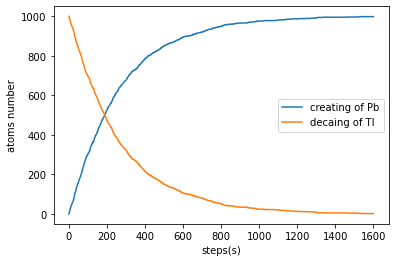

In [2]:
def prob(t):
    return 1-(2**(-t/(3.052*60)))

# generate probability sampling distribution for each atom Tl for deciding
n = 1000
u = np.random.uniform(0, 1, n)

# accept-reject criterion for each atom in probability sampling distribution

# creating Pb
Pb = []
for i in range(1600):
    Pb = Pb + [len(u[u < prob(i)])]

# decaing Tl    
Tl = []
for i in range(1600):
    Tl = Tl + [1000-int(Pb[i])]
    
plt.plot(Pb, label="creating of Pb")
plt.plot(Tl, label="decaing of Tl")
plt.xlabel("steps(s)")
plt.ylabel("atoms number")
plt.legend()
plt.show()


In [4]:
# the inverse transform method

def expon_pdf(x):
    """PDF of exponential distribution."""
    return (2**(-t/(3.052*60)))*(np.log(2)/((3.052*60)))

def expon_cdf(x):
    """CDF of exponetial distribution."""
    return 1 - np.exp2(-(x)/(3.052*60))

def expon_icdf(z): # it is the time of decay of the 1000 Tl atoms.
    """Inverse CDF of exponential distribution - i.e. quantile function."""
    return -(np.log2(1-z))*(3.052*60)

Text(0, 0.5, 'steps ')

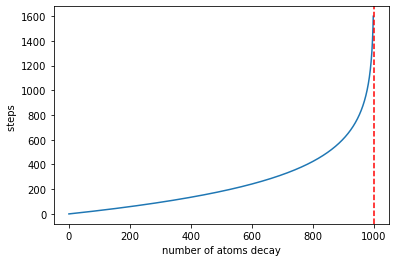

In [13]:
# time of decay with the inverse transform method
z=expon_cdf(np.arange(1600))   
plt.plot(1000*z,expon_icdf(z))
plt.axvline(1000, linestyle = "--", color = "r")
plt.xlabel("number of atoms decay")
plt.ylabel("steps ")

Text(0, 0.5, 'number of atoms not decay ')

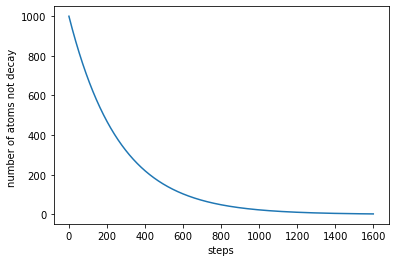

In [14]:
# the number of atoms that have not decayed as a function of time.
plt.plot(np.arange(1600),1000*(1-expon_cdf(np.arange(1600))))
plt.xlabel("steps")
plt.ylabel("number of atoms not decay ")


2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [17]:
def teta(b):
    E = (7.7)*(10**6)*(sc.e)
    z_gold = 79
    return 2 * np.arctan((z_gold*(sc.e**2)) / (2*(np.pi)*(sc.epsilon_0)*E*b))

sigma = sc.physical_constants['Bohr radius'][0]/100
z = np.random.rand(1000000) # the z in Box-Muller method is a simple uniform distribution.
b = np.sqrt(-2*(sigma**2)*(np.log(1-z))) # Box-Muller method, b is the impact parameter
                                         # of the x and y. so b is 2D that are given by
                                         # Box-Muller method so represented by 
                                         # a 2D gaussian distribution.
teta = teta(b)
teta_back = teta[teta>np.pi/2]

print("number of particles that bounce back:", len(teta_back))
print("Fraction of particles that bounce back:",len(teta_back)/1000000)

number of particles that bounce back: 1608
Fraction of particles that bounce back: 0.001608


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

numerical antegral of f(x): 1.4514015822549398


<ipython-input-19-6c354c7495f4>:6: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I_numerical = integrate.quad(f,0,2,limit=100000)


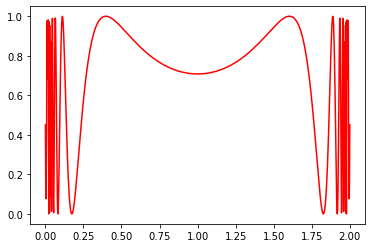

In [19]:
def f(x):
    return (np.sin(1/(x*(2-x))))**2

x=np.linspace(0.001,1.999,1000)
plt.plot(x,f(x),'r-')
I_numerical = integrate.quad(f,0,2,limit=100000)
print ("numerical antegral of f(x):", I_numerical[0])

In [20]:
# The hit/miss method

N = 100000
count = 0
for i in range(N):
    x = 2*np.random.random()
    y = np.random.random()
    if y<f(x): count+=1
I_h = (2*count)/N
print ("estimate antegral of f(x) by the hit/miss method:", I_h)
print ("relative error:", np.abs(I_h - I_numerical[0])/I_numerical[0])

estimate antegral of f(x) by the hit/miss method: 1.45192
relative error: 0.0003571842220641038


In [21]:
# The  mean value method

N = 100000
count = 0
for i in range(N):
    x = 2*np.random.random()
    count+=f(x)
I_m = (2*count)/N
print ("estimate antegral of f(x) by the mean method:", I_m)
print ("relative error:", np.abs(I_m - I_numerical[0])/I_numerical[0])

estimate antegral of f(x) by the mean method: 1.4515072507571511
relative error: 7.280445570909268e-05


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [22]:
# 2D
D = 2
def f_x_y(x):
    if np.sum(x**2)<=1:
        return 1
    else:
        return 0
    
N = 100000
count = 0
for i in range(N):
    x = np.random.random(D)
    count+=f_x_y(x)
I_m = ((2**D)*count)/N
print ("The estimate area of a circle of unit radius by the mean method in 2D:", I_m)    
    

The estimate area of a circle of unit radius by the mean method in 2D: 3.1404


In [23]:
# 10D
D = 10
def f_x_y(x):
    if np.sum(x**2)<=1:
        return 1
    else:
        return 0
    
N = 100000
count = 0
for i in range(N):
    x = np.random.random(D)
    count+=f_x_y(x)
I_m = ((2**D)*count)/N
print ("The estimate area of a circle of unit radius by the mean method in 10D:", I_m)    
    

The estimate area of a circle of unit radius by the mean method in 10D: 2.39616


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [24]:
def f(x):
    return (x**(-1/2))/((np.e**x)+1)
def w(x):
    return 1/(np.sqrt(x))

# integral of w(x) with mean value method
N = 100000
count = 0
for i in range(N):
    x = np.random.random()
    count+=w(x)
I_w_x = (1*count)/N
print ("estimate antegral of w(x) by the mean method:", I_w_x)
print ("relative error:", np.abs(I_w_x - 2)/2)

estimate antegral of w(x) by the mean method: 1.9896813909911384
relative error: 0.005159304504430806


In [25]:
N = 100000
count = 0
for i in range(N):
    x = np.random.random()
    count+=f(x)/w(x)
I_m = (count*I_w_x)/N
print ("estimate antegral of f(x) by the mean method:", I_m)
print ("relative error:", np.abs(I_m - 0.84)/0.84)

estimate antegral of f(x) by the mean method: 0.756088466485666
relative error: 0.09989468275515953
